In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################


這次的範例主要參考[ShangtongZhang](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter07/random_walk.py)

Chapter 6主要帶入TD(0)的概念，但是從TD(0)去延伸、擴展，學習演算法可以變成$n-$step，而當你的$n=T$的時候，它就是MC，這是一個很大的結合。

Example 7.1: n-step TD Methods on the Random Walk

這邊把之前Example 6.2的範例改用$n-$step TD來處理。
![](https://i.imgur.com/7RgWEIz.png)

假設，第一個episode就從$C$開始，然後往右經過$D, E$，成功的進到終止狀態，得到1的reward。現在讓我們回想一下，所有狀態的起始估測值皆為0.5，即$v(s)=0.5$。以這個經驗的結果來看，如果是one-step，那只有最後一個state估測值會變更，也就是$V(E)$，會往1的方向去增加。如果是two-step的話，那變更的就會是$V(D), V(E)$同時往1的方向增加。在$n>2$的情況下，所有經過的state都會以相同的大小來更新其value。

這樣子，我們應該怎麼選擇這個$n$呢？Figure 7.2給出這個簡單實際測試的結果，不過這邊實驗的是19個states，而不是Example 6.2中的5個states，左邊的reward是-1，然後所有的value的初始值皆為0，這章後續的範例也都是這樣的。呈現出的是$n-$step TD methods用區間值內不同的$n, \alpha$的測試結果。橫軸是$\alpha$，不同的線代表不同的$n$，然後縱軸是這19個states前10個episodes完整實驗100次取平均得到的預測值與真實值之間的均方誤差的平方根。可以明顯看的出來，$n$取中間值($n=4$)的效果最好，相對的說明$n-$step的效果會比TD還有MC還要來的好。

![](https://i.imgur.com/ju1o1Sw.png)
Figure 7.2: Performance of $n$-step TD methods as a function of $\alpha$, for various values of $n$, on a 19-state random walk task (Example 7.1).

首先載入需求套件

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

設置環境參數

根據範例說明，這次的state有19個

In [3]:
STATE_NUM = 19
STATE_SPACE = np.arange(1, STATE_NUM + 1)
STATE_SPACE

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

start state是中間那一個


In [4]:
START_STATE = np.median(STATE_SPACE).astype(np.uint8)
START_STATE

10

terminal state有兩個，最左跟最右

In [5]:
TERMINAL_STATES = [0, STATE_NUM + 1]
TERMINAL_STATES

[0, 20]

這是一個NONDISCOUNT的範例

In [6]:
DISCOUNT_FACTOR = 1

設置states的true value

In [7]:
TRUE_VALUE = np.arange(-20, 22, 2) / 20.0
TRUE_VALUE[0] = TRUE_VALUE[-1] = 0
TRUE_VALUE

array([ 0. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  0. ])

設置學習演算法

下面給出演算法說明

![](https://i.imgur.com/7uUAZUl.png)

$$G_{t:t+n} \dot{=} R_{t+1} + \gamma R_{t+2} + \cdots + \gamma^{n-1}R_{t+n} + \gamma^nV_{t+n-1}(S_{t+n}) \tag{7.1}$$

In [8]:
def td(values, n, alpha):
    # init state
    state = START_STATE
    
    # 記錄episodes中的state、reward
    states = [state]
    rewards = [0]
    
    # 記錄當前的time step
    time = 0
    
    # 假設，這個episode的長度是無限大大大，因為你根本不知道他什麼時候會結束
    T = float('inf')
    
    while True:
        time += 1
        
        if time < T:
            # 隨機選擇一個action
            if np.random.binomial(1, 0.5) == 1:
                next_state = state - 1
            else:
                next_state = state + 1
            
            # 判斷reward
            if next_state == 0:
                reward = -1
            elif next_state == 20:
                reward = 1
            else:
                reward = 0
            
            # 寫入記錄
            states.append(next_state)
            rewards.append(reward)
            
            if next_state in TERMINAL_STATES:
                # 這錄這個episode的終止時間
                T = time
    
        # 處理backup，n-step，因此我們會從time t去減n來更新我們要反推的time step
        # 舉例來說，現在的time=3，n=2，那3-2=1，我們更新的就是time=1的value
        tau = time - n
        if tau >= 0:            
            returns = 0.0
            # 迴圈處理的就是公式7.1屬於rewrd的部份
            for t in range(tau + 1, min(T, tau + n) + 1):
                # 加總相關的rewards
                returns += pow(DISCOUNT_FACTOR, t - tau - 1) *  rewards[t]
            
            # 把state values也加進去reutnrs
            # 這邊處理的就是公式7.1最後面那個預估的部份
            if tau + n <= T:
                returns += pow(DISCOUNT_FACTOR, n) * values[states[(tau + n)]]
                
            # n-step，我們更新的就是t - n
            # 所以這邊取得的就是我們真的要更新的那一個state
            # 假設n=2,t=3，那更新的就是tau所在的那個索引的state，也就是3-2=1
            state_to_update = states[tau]
            if not state_to_update in TERMINAL_STATES:
                values[state_to_update] += alpha * (returns - values[state_to_update])
        
        if tau == T - 1:
            break
        
        state = next_state
                    
            

下面執行演算法

根據圖表，n是$2^1 \sim 2^9$

In [9]:
steps = np.power(2, np.arange(0, 10))
steps

array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512])

根據圖表設置alpha

In [10]:
alphas = np.arange(0, 1.1, 0.1)
alphas

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

定義執行次數

In [11]:
episodes = 10
runs = 100

執行

In [12]:
errors = np.zeros((len(steps), len(alphas)))
for run in tqdm(range(0, runs)):
    for step_idx, step in enumerate(steps):
        for alpha_idx, alpha in enumerate(alphas):
            
            # 記錄value，state的數量加上頭尾兩個terminal state
            values = np.zeros(STATE_NUM + 2)
            for episode in range(episodes):
                td(values, step, alpha)
                # 計算RMS error，也就是均方根誤差
                errors[step_idx, alpha_idx] += np.sqrt(np.sum(np.power(values - TRUE_VALUE, 2)) / STATE_NUM)                

100%|██████████| 100/100 [07:47<00:00,  4.67s/it]


計算平均

In [14]:
# 只是留個複本，避免操作錯誤要重新執行
old_errors = errors.copy()
errors /= episodes * runs

繪製圖面

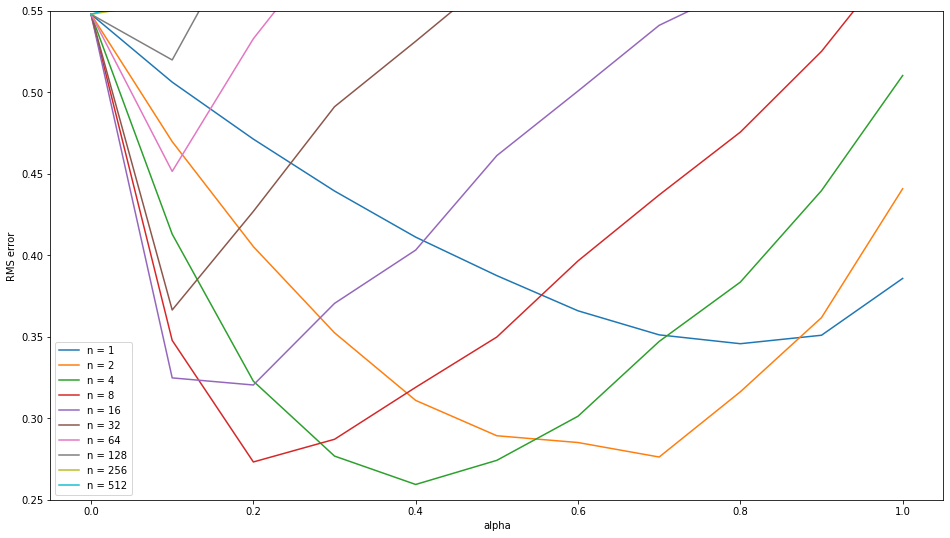

In [17]:
plt.figure(figsize=(16, 9))    
for i in range(0, len(steps)):
    plt.plot(alphas, errors[i, :], label='n = %d' % (steps[i]))

plt.xlabel('alpha')
plt.ylabel('RMS error')
plt.ylim([0.25, 0.55])
plt.legend()
plt.show()